In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

d:\conda\envs\cybercare\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Exploratory data analysis

In [2]:
# Load the data
data = pd.read_parquet('cc_data.parquet')

# Display basic info
print("INFO:")
data.info()
print("HEAD:\n", data.head())
print("DESCRIBE:\n", data.describe())

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16882 entries, 0 to 16881
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TITLE                 16882 non-null  object
 1   ABSTRACT              16882 non-null  object
 2   Computer Science      16882 non-null  int64 
 3   Physics               16882 non-null  int64 
 4   Mathematics           16882 non-null  int64 
 5   Statistics            16882 non-null  int64 
 6   Quantitative Biology  16882 non-null  int64 
 7   Quantitative Finance  16882 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.0+ MB
HEAD:
                                                TITLE  \
0  Characterization of multivariate Bernoulli dis...   
1  Distinction of representations via Bruhat-Tits...   
2  On the origin of the shallow and "replica" ban...   
3  Explaining Recurrent Neural Network Prediction...   
4  Estimators of the correlation coefficient in t

Number of papers per subject:
Computer Science        6935
Physics                 4788
Mathematics             4523
Statistics              4183
Quantitative Biology     478
Quantitative Finance     200
dtype: int64


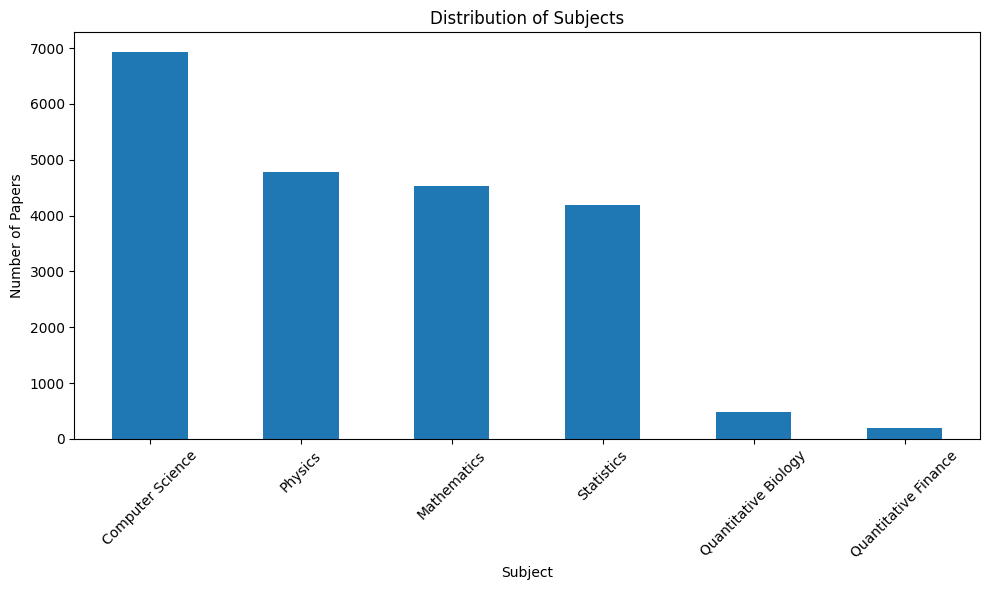

Average title length: 72.84320578130553
Average abstract length: 1007.3418433834854


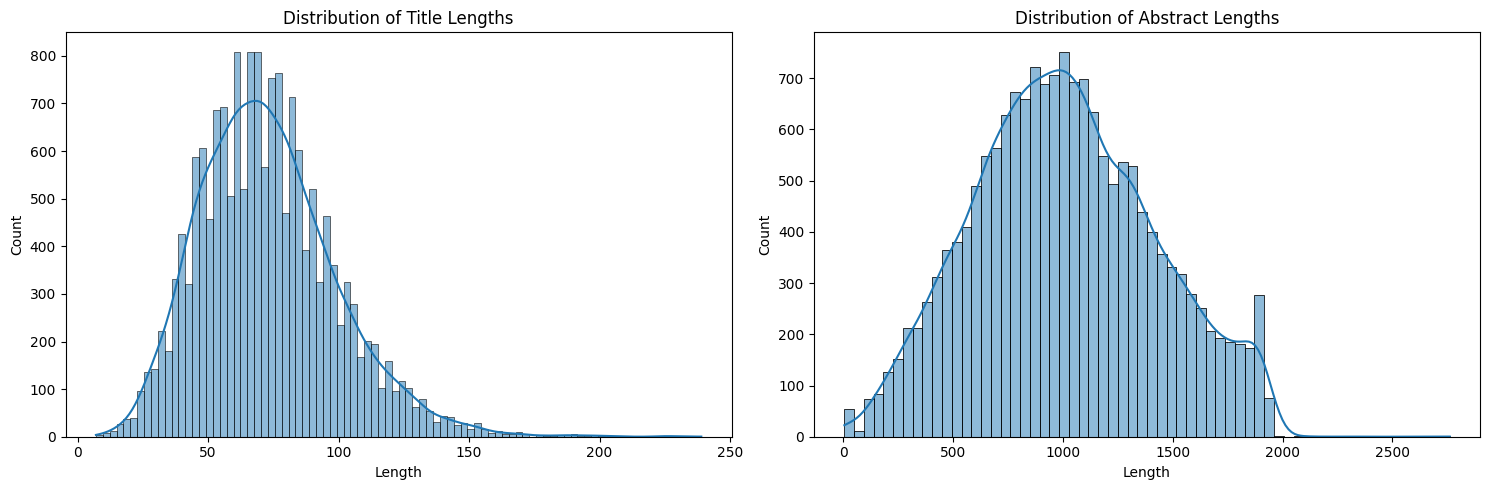

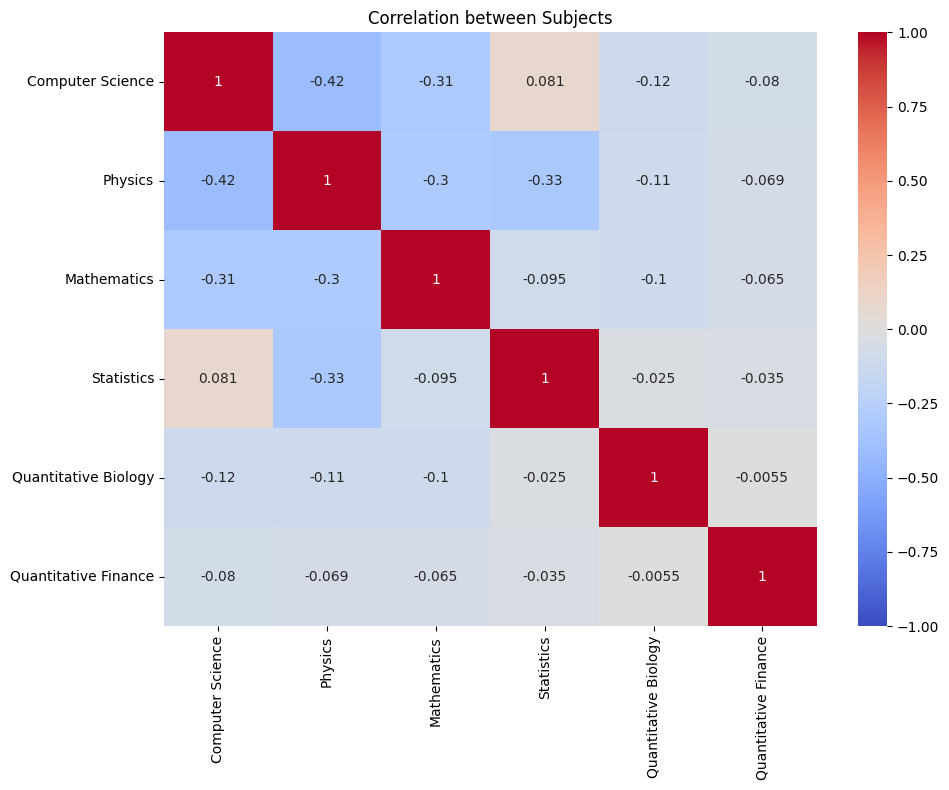

In [3]:
# Count the number of papers for each subject
subject_counts = data[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']].sum()
print("Number of papers per subject:")
print(subject_counts)

# Visualize the distribution of subjects
plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar')
plt.title('Distribution of Subjects')
plt.xlabel('Subject')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the average length of titles and abstracts
data['title_length'] = data['TITLE'].str.len()
data['abstract_length'] = data['ABSTRACT'].str.len()

print("Average title length:", data['title_length'].mean())
print("Average abstract length:", data['abstract_length'].mean())

# Visualize the distribution of title and abstract lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['title_length'], kde=True, ax=ax1)
ax1.set_title('Distribution of Title Lengths')
ax1.set_xlabel('Length')
sns.histplot(data['abstract_length'], kde=True, ax=ax2)
ax2.set_title('Distribution of Abstract Lengths')
ax2.set_xlabel('Length')
plt.tight_layout()
plt.show()

# Calculate the correlation between subjects
subject_correlation = data[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(subject_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Subjects')
plt.tight_layout()
plt.show()

In [4]:
# Why do we have short abstracts?
short_abstracts = data[data['ABSTRACT'].str.len() < 100]
print(f"\nNumber of abstracts with less than 100 characters: {len(short_abstracts)}")
print("\nFirst 10 short abstracts:")
for i, (index, row) in enumerate(short_abstracts.iterrows()):
    if i >= 10:
        break
    print(f"\nAbstract {i+1}:")
    print(f"Title: {row['TITLE']}")
    print(f"Abstract: {row['ABSTRACT']}")
    print(f"Length: {len(row['ABSTRACT'])}")
    print(f"Subjects: {', '.join([subj for subj in row.index[2:8] if row[subj] == 1])}")

# The abstracts are short because the subject is obvious from the title. Abstract 3 is an example of a short abstract that is garbage data.


Number of abstracts with less than 100 characters: 74

First 10 short abstracts:

Abstract 1:
Title: Virtual link and knot invariants from non-abelian Yang-Baxter 2-cocycle pairs
Abstract: For...
Length: 6
Subjects: Mathematics

Abstract 2:
Title: A short proof of the error term in Simpson's rule
Abstract:   In this paper we present a short and elementary proof for the error in
Simpson's rule.

Length: 89
Subjects: Mathematics

Abstract 3:
Title: Determination and biological application of a time dependent thermal parameter and sensitivity analysis for a conduction problem with superficial evaporation
Abstract: A...
Length: 4
Subjects: Physics

Abstract 4:
Title: Thicket Density
Abstract: Thicket...
Length: 10
Subjects: Mathematics

Abstract 5:
Title: A Note on Kaldi's PLDA Implementation
Abstract:   Some explanations to Kaldi's PLDA implementation to make formula derivation
easier to catch.

Length: 95
Subjects: Statistics

Abstract 6:
Title: Photonic Band Structure of Two-dimensiona

In [5]:
# Word Frequency Analysis
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for subject in ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']:
    print(f"\nTop 10 words in {subject}:")
    top_words = get_top_n_words(data[data[subject] == 1]['ABSTRACT'], n=10)
    print(top_words)


Top 10 words in Computer Science:
[('data', 5111), ('model', 4080), ('based', 4030), ('learning', 3848), ('paper', 3364), ('network', 3197), ('problem', 3193), ('algorithm', 2982), ('time', 2980), ('using', 2976)]

Top 10 words in Physics:
[('model', 2277), ('using', 1779), ('field', 1745), ('time', 1645), ('results', 1643), ('energy', 1618), ('data', 1534), ('high', 1500), ('based', 1389), ('phase', 1387)]

Top 10 words in Mathematics:
[('paper', 1655), ('problem', 1520), ('results', 1414), ('mathbb', 1335), ('prove', 1221), ('model', 1157), ('study', 1140), ('function', 978), ('space', 970), ('method', 963)]

Top 10 words in Statistics:
[('data', 4361), ('learning', 3276), ('model', 3236), ('based', 2281), ('models', 2193), ('method', 2021), ('methods', 1835), ('algorithm', 1787), ('paper', 1768), ('using', 1739)]

Top 10 words in Quantitative Biology:
[('model', 394), ('data', 361), ('networks', 294), ('network', 260), ('based', 222), ('models', 207), ('time', 191), ('results', 186

# Data preprocessing

In [6]:
# Settings to remove warnings
pd.options.mode.copy_on_write = True

class ScientificPaperDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 512  # BERT's maximum sequence length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

def preprocess_data(data, test_size=0.2, random_state=12345):
    # Combine TITLE + ABSTRACT
    data['text'] = data['TITLE'] + ' ' + data['ABSTRACT']

    # Remove entries with very short text
    data = data[data['text'].str.len() > 30]

    # Common text preprocessing
    data['text'] = data['text'].str.lower()
    data['text'] = data['text'].str.replace('[^a-zA-Z\s]', '', regex=True)
    data['text'] = data['text'].str.replace('\s+', ' ', regex=True).str.strip()

    # Prep labels
    labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data[labels].sum(axis=1))

    # Datasets
    train_dataset = ScientificPaperDataset(train_data['text'].tolist(), train_data[labels].values.tolist())
    val_dataset = ScientificPaperDataset(val_data['text'].tolist(), val_data[labels].values.tolist())

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=16):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

train_dataset, val_dataset = preprocess_data(data)
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

In [14]:
# Suppress annoying warnings
# A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning. 
# A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.

from transformers import logging
logging.set_verbosity_error()

class BERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

def compute_class_weights(labels, device):
    # Class imbalance correction
    labels = np.array(labels)
    class_counts = labels.sum(axis=0)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    return torch.FloatTensor(class_weights).to(device)

def train_model(model, train_loader, val_loader, num_epochs, device, class_weights):
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        val_loss, val_f1, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return model

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    val_loss /= len(data_loader)
    f1 = f1_score(all_labels, (all_preds > 0.5).astype(int), average='micro')
    accuracy = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    
    return val_loss, f1, accuracy

def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
    
    return np.array(all_preds)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
num_labels = 6 # CS, Physics, Math, Stats, QB, QF
model = BERTClassifier(num_labels).to(device)

class_weights = compute_class_weights(train_dataset.labels, device)
num_epochs = 5

trained_model = train_model(model, train_loader, val_loader, num_epochs, device, class_weights)
torch.save(trained_model.state_dict(), 'bert_classifier.pth')

Using device: cpu


KeyboardInterrupt: 

In [ ]:
# Prediction
test_data = pd.read_parquet('cc_test.parquet')
test_dataset = ScientificPaperDataset(test_data['text'].tolist(), [[0]*num_labels]*len(test_data))  # Dummy labels
test_loader = DataLoader(test_dataset, batch_size=16)
predictions = predict(trained_model, test_loader, device)

test_data[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']] = predictions
test_data.to_parquet('predictions.parquet')